In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG, PATH_LOG

In [ ]:
top_k = 50

drop_columns = [
    "device",
    "learning_rate",
    "batch_size",
    "top_k",
    "seed",
    "epochs",
    "datasets",
    "log"
]

if False:
    for k in CONFIG.top_k:
        if k != top_k:
            drop_columns.extend([f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}"])

print(drop_columns)

['device', 'learning_rate', 'batch_size', 'top_k', 'seed', 'epochs', 'datasets', 'log']


In [ ]:
files = os.listdir(PATH_LOG)
settings = {}

for fname in files:
    with open(PATH_LOG / fname, "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, train_loss, val_loss, *res = lines[-1].strip().split("\t")

        s = lines[0].split("alpha:")
        lines[0] = s[0]

        d = json.loads(lines[0])

        if len(s) == 2:
            alpha = s[1]
            d["Alpha"] = alpha

        d["Epochs"] = int(epochs)
        d["T-Loss"] = float(train_loss)
        d["V-Loss"] = float(val_loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i * 3:(i * 3)+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)

df

KeyError: "['device', 'learning_rate', 'batch_size', 'top_k', 'seed', 'epochs', 'datasets', 'log'] not found in axis"

In [ ]:
df.where((df["dataset"] == "ml1m") & (df["normalized"] == True)).drop(columns=["dataset", "alpha", "autoencoder", "embedding_dim", "ensemble_fusion", "freeze", "fusion_modalities", "info_nce", "single_branch", "Epochs", "fusion_type", "Alpha"]).dropna().drop_duplicates()

,multimodal,n_layers,normalized,T-Loss,V-Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50


In [ ]:
file = list(sorted(os.listdir(PATH_LOG)))[-1]
#file = "2025-03-09T10:48:12.log"
file_path = PATH_LOG / file

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config_line = config_line.split("alpha:")[0]
    config = json.loads(config_line)

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [ ]:
epochs = data["Epoch"]
train_loss = data["T-Loss"]
val_loss = data["V-Loss"]

{'device': 'cuda:1',
 'multimodal': False,
 'embedding_dim': 512,
 'n_layers': 2,
 'epochs': 500,
 'learning_rate': 0.001,
 'log': True,
 'seed': 19,
 'top_k': [5,
           10,
           20,
           50],
 'dataset': 'ml1m',
 'batch_size': 4096,
 'alpha': False,
 'autoencoder': False,
 'ensemble_fusion': False,
 'freeze': False,
 'fusion_modalities': 'mean',
 'fusion_type': 'late',
 'info_nce': False,
 'normalized': False,
 'single_branch': False,
 'datasets': {'dbbook': ['images',
                         'text'],
              'ml1m': ['audio',
                       'images',
                       'text',
                       'video']}}

Epoch           500.0000
T-Loss            0.0645
V-Loss            0.3948
Precision@5       0.2362
Recall@5          0.0982
NDCG@5            0.2563
Precision@10      0.2010
Recall@10         0.1619
NDCG@10           0.2484
Precision@20      0.1622
Recall@20         0.2502
NDCG@20           0.2572
Precision@50      0.1142
Recall@50         

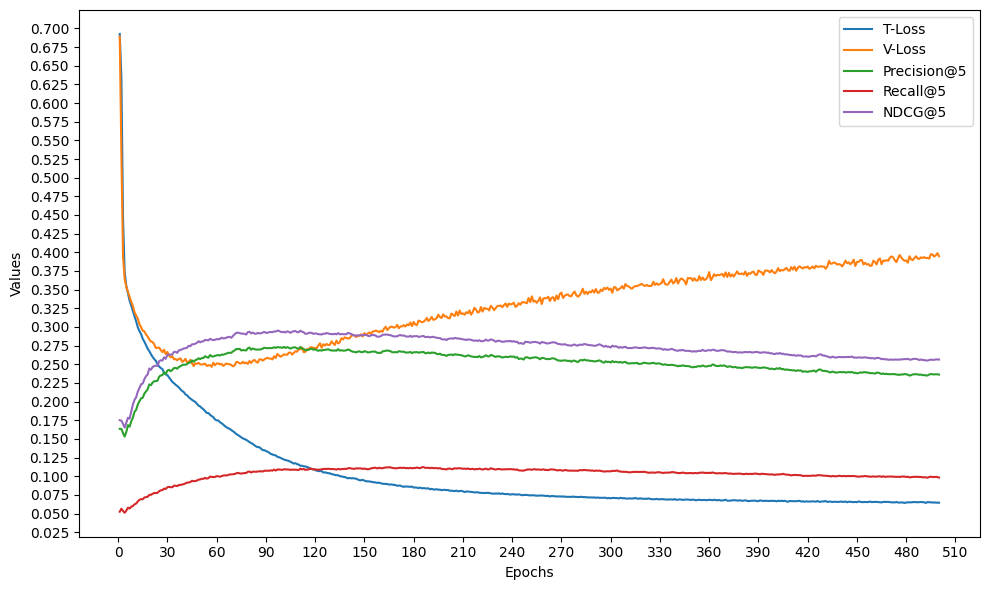

In [ ]:
pp(config, width=1)
print()

json_config = pd.read_json(data.iloc[-1])
print(json_config)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, label="T-Loss")
plt.plot(epochs, val_loss, label="V-Loss")

for k in [50]:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
#plt.title(file_path)
plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
#plt.yscale("log")

plt.tight_layout()
plt.show()